# Setup

## Colab

In [1]:
# Mount the drive and move to dir
from google.colab import drive
drive.mount("/content/drive", force_remount = False)
%cd /content/drive/MyDrive/Coding/spread-res/runscr/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Coding/spread-res/runscr


## Imports

In [ ]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import os
import sys

import torch

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

# Import the model architecture
# from classes.models import BertPos

# Import the utilities and the dataloader
from utils import inferutil, setuputil, trainutil

# Now reload the modules to ensure they are up-to-date
importlib.reload(setuputil)
importlib.reload(trainutil)
importlib.reload(inferutil)
# importlib.reload(BertPos)

# Import the model and funcs required from utils
# from classes.models.BertPos import BertPos
from utils.inferutil import infer_full, infer_one
from utils.setuputil import display_config, setup_config
from utils.trainutil import train_model

## Configuration

Default vars invisible below with their default values:

device = cuda/mps:0 (env-specific), threads = 1 to inf (env-specific), seed = 0 to inf, data_dir = ../data, rows = 100, cols = 100, tokens = 32, save_dir = ../models/

In [ ]:
# Restart
from utils import setuputil

importlib.reload(setuputil)
from utils.setuputil import display_config, setup_config

# Setup the config
# input_config = {
#     # Environment and Model Info
#     "env": "colab",
#     "approach": "bert",
#     "model_name": "BertGridNew",
#     "model_base": "bert-base-cased",
#     "data_ds": "1k",
#     # BERT Architecture Parameters
#     "vocab_size": 30522,
#     "hidden_size": 32,
#     "num_hidden_layers": 1,
#     "num_attention_heads": 1,
#     "intermediate_size": 128,
#     "gradient_checkpointing": False,
#     # Training Parameters
#     "batch_size": 12,
#     "lr": 1e-3,
#     "mu": 0.25,
#     "epochs": 100,
#     "patience": 2,
#     "save_int": 20,
# }

input_config = {
    # Environment and Model Info
    "env": "local",
    "approach": "bert",
    "model_name": "BertGridNew",
    "model_base": "bert-base-cased",
    "data_ds": "manual",
    "DEVICE": "mps:0",
    # BERT Architecture Parameters
    "vocab_size": 30522,
    "hidden_size": 32,
    "num_hidden_layers": 1,
    "num_attention_heads": 1,
    "intermediate_size": 128,
    "gradient_checkpointing": False,
    # Training Parameters
    "batch_size": 20,
    "lr": 1e-2,
    "mu": 0.25,
    "epochs": 10,
    "patience": 2,
    "save_int": 0,
}
config = setup_config(input_config)
display_config(config)

# Define local variables from the config dictionary
DEVICE = config["DEVICE"]
THREADS = config["THREADS"]

# Data loaders and vocab
train_loader = config["train_loader"]
val_loader = config["val_loader"]
test_loader = config["test_loader"]
tokenizer = config["tokenizer"]
model_base = config["model_base"]

# Training parameters
batch_size = config["batch_size"]
lr = config["lr"]
mu = config["mu"]
epochs = config["epochs"]
patience = config["patience"]
save_int = config["save_int"]
save_dir = config["save_dir"]
save_name = config["save_name"]

Processing files: 100%|██████████| 40/40 [00:06<00:00,  6.60it/s]



40(P) = 40(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 5542.16it/s]



5(P) = 5(G) + 0(E)


Processing files: 100%|██████████| 5/5 [00:00<00:00, 8237.05it/s]



5(P) = 5(G) + 0(E)

FINAL CONFIG:
{
  "env": "local",
  "approach": "bert",
  "DEVICE": "<device>",
  "THREADS": 8,
  "seed": 0,
  "model_base": "bert-base-cased",
  "model_name": "BertGridNew",
  "rows": 100,
  "cols": 100,
  "tokens": 32,
  "data_ds": "manual",
  "data_dir": "../data",
  "train_dir": "../data/manual_train",
  "val_dir": "../data/manual_val",
  "test_dir": "../data/manual_test",
  "tokenizer": "<BertTokenizerFast>",
  "vocab_size": 30522,
  "hidden_size": 32,
  "num_hidden_layers": 1,
  "num_attention_heads": 1,
  "intermediate_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "attention_probs_dropout_prob": 0.1,
  "max_position_embeddings": 64,
  "type_vocab_size": 2,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "pad_token_id": 0,
  "gradient_checkpointing": false,
  "train_loader": "<LoaderBert>",
  "val_loader": "<LoaderBert>",
  "test_loader": "<LoaderBert>",
  "batch_size": 20,
  "lr": 0.01,
  "mu": 0.25,
  "epochs": 10,
  "patienc

# NEW TESTER

## Model Creation -> Single Example Check

In [ ]:
# Imports
import math
import time

import torch
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoModel, BertConfig, BertModel
from transformers.models.bert.modeling_bert import BertEncoder


# 717 MB model on self
# Define the BertGridNew class
class BertGridNew(nn.Module):
    """A BERT-based model that combines positional and content understanding for grid-structured data.

    This model processes grid-structured input through BERT embeddings enriched with positional
    encodings for both row and column positions. It uses a combination of BERT encoding and
    positional information to create a rich representation of grid cells.

    Args:
    config (dict): Configuration dictionary containing model parameters.
    """

    def __init__(self, config):
        super().__init__()

        # Disable efficient sdp causes problem
        torch.backends.cuda.enable_mem_efficient_sdp(False)

        # Extract common params
        self.device = config["DEVICE"]
        self.rows = config["rows"]
        self.cols = config["cols"]
        self.seq_len = config["tokens"]
        self.hidden_size = config["hidden_size"]
        self.hidden_dropout_prob = config["hidden_dropout_prob"]

        # Create config to be used for both base model and encoder
        self.bert_config = BertConfig(
            vocab_size=config["vocab_size"],
            hidden_size=self.hidden_size,
            intermediate_size=config["intermediate_size"],
            num_hidden_layers=config["num_hidden_layers"],
            num_attention_heads=config["num_attention_heads"],
            hidden_act=config["hidden_act"],
            hidden_dropout_prob=self.hidden_dropout_prob,
            attention_probs_dropout_prob=config["attention_probs_dropout_prob"],
            max_position_embeddings=config["max_position_embeddings"],
            type_vocab_size=config["type_vocab_size"],
            layer_norm_eps=config["layer_norm_eps"],
            initializer_range=config["initializer_range"],
            pad_token_id=config["pad_token_id"],
            gradient_checkpointing=config["gradient_checkpointing"],
            seed=config["seed"],
        )

        # Initialize both the BERT model and the enriched encoder using the same config.
        self.bertModel_cell = BertModel(self.bert_config)
        self.bertEncoder_spatial = BertEncoder(self.bert_config)

        # Precompute pos encs for grid cells [max(rows, cols), hidden_size]
        self.pos_encodings = self.get_posEncoding(self.rows, self.cols)

        # Final binary classification layers wrapped sequentially
        self.binary_classifier = nn.Sequential(
            nn.Dropout(self.hidden_dropout_prob),
            nn.GELU(),
            nn.Linear(self.hidden_size, 1),
        )

    # Function to get positional encodings for cells
    def get_posEncoding(self, num_rows, num_cols):
        """Generates optimized positional encodings for grid cells using sinusoidal functions.

        Optimized version that uses broadcasting and combined calculations to reduce
        computational overhead while maintaining the same mathematical properties as
        the original implementation.
        """
        # Calculate all position indices at once to get row/col indices
        positions = torch.arange(num_rows * num_cols, device=self.device)
        i = positions // num_cols
        j = positions % num_cols

        # Create hidden dimension vector for frequency calculations
        frequency_base = 8.0 * (
            torch.arange(self.hidden_size, device=self.device) + (j[:, None] % 2)
        )

        # Return [batch_size, rows * cols, hidden_size] tensor with formula
        return (
            (torch.sin(i[:, None] / (10 ** (frequency_base / num_rows))))
            + (torch.sin(j[:, None] / (10 ** (frequency_base / num_cols))))
        ).unsqueeze(0)

    # Newer highly vectorized and optimized forward
    def forward(self, input_ids, attention_mask):

        # Retrieve dims
        batch_size, rows, cols, seq_len = input_ids.shape

        # Generate the S_cube and return directly
        return (
            self.binary_classifier(
                self.bertEncoder_spatial(
                    (
                        (
                            self.bertModel_cell(
                                input_ids=input_ids.reshape(-1, seq_len),
                                attention_mask=attention_mask.reshape(-1, seq_len),
                            ).pooler_output.reshape(
                                batch_size, rows * cols, self.hidden_size
                            )
                        )
                        + (self.pos_encodings.to(input_ids.device))
                    )
                )[0]
            )
            .squeeze(-1)
            .reshape(batch_size, rows, cols)
        )

In [ ]:
import importlib
import time

from utils import selfutil

importlib.reload(selfutil)

from utils.selfutil import compare_sCube, oneBatch_check

ex_file, ex_xtok, ex_xmasks, ex_ytok = oneBatch_check(
    batch_size=10, data_loader=train_loader, device=DEVICE
)

untrained_model = BertGridNew(config).to(DEVICE)
untrained_model.eval()

with torch.no_grad():
    # start_time_forward2 = time.time()
    # out2 = untrained_model.forward2(ex_xtok, ex_xmasks)
    # elapsed_forward2 = time.time() - start_time_forward2
    # print(f"NEW forward2: {elapsed_forward2:.3f} seconds")

    start_time_forward = time.time()
    out = untrained_model.forward(ex_xtok, ex_xmasks)
    elapsed_forward = time.time() - start_time_forward
    print(f"OLD forward: {elapsed_forward:.3f} seconds")

# compare_sCube(out, out2, ex_file, tolerance=1e-6)

Filenames:	['../data/manual_train/idrportfolio-by-debt-size.xls', '../data/manual_train/dlportfoliobydelinquencystatus.xls', '../data/manual_train/dlportfolio-by-debt-size.xls', '../data/manual_train/harassment-bullying-on-basis-of-race-reported copy.xlsx', '../data/manual_train/dlportfolio-by-age.xls', '../data/manual_train/portfoliobyloantype copy.xls', '../data/manual_train/harassment-bullying-on-basis-of-race-disciplined.xlsx', '../data/manual_train/advanced-placement-enrollment copy.xlsx', '../data/manual_train/dlbyforbearancetype copy.xls', '../data/manual_train/harassment-bullying-on-basis-of-disability-disciplined.xlsx']
Tok Tensor Shapes:	torch.Size([10, 100, 100, 32]),	torch.Size([10, 100, 100, 17])

OLD forward: 0.286 seconds


In [ ]:
def get_posEncoding(num_rows, num_cols, hidden_size, device):
    """Generates optimized positional encodings for grid cells using sinusoidal functions.

    This version accepts hidden_size and device as parameters.
    """
    # Calculate all position indices at once to get row/col indices
    positions = torch.arange(num_rows * num_cols, device=device)
    i = positions // num_cols
    j = positions % num_cols

    # Create hidden dimension vector for frequency calculations
    frequency_base = 8.0 * (torch.arange(hidden_size, device=device) + (j[:, None] % 2))

    # Combine components to get final encodings
    posEncoding = (torch.sin(i[:, None] / (10 ** (frequency_base / num_rows)))) + (
        torch.sin(j[:, None] / (10 ** (frequency_base / num_cols)))
    )

    # Return [batch_size, rows * cols, hidden_size] tensor for broadcasting
    return posEncoding.unsqueeze(0)


def get_posEncoding2(num_rows, num_cols, hidden_size, device):
    """Generates optimized positional encodings for grid cells using sinusoidal functions.

    This version accepts hidden_size and device as parameters.
    """
    # Calculate all position indices at once to get row/col indices
    positions = torch.arange(num_rows * num_cols, device=device)
    i = positions // num_cols
    j = positions % num_cols

    # Create hidden dimension vector for frequency calculations
    frequency_base = 8.0 * (torch.arange(hidden_size, device=device) + (j[:, None] % 2))

    # Combine components to get final encodings
    return (
        (torch.sin(i[:, None] / (10 ** (frequency_base / num_rows))))
        + (torch.sin(j[:, None] / (10 ** (frequency_base / num_cols))))
    ).unsqueeze(0)

In [ ]:
# Example inputs
num_rows, num_cols = 5, 5
hidden_size = 32
# Assume "model" is an instance of the class containing these methods and self.device is appropriately set.
pos_encoding1 = get_posEncoding(num_rows, num_cols, hidden_size, DEVICE)
pos_encoding2 = get_posEncoding2(num_rows, num_cols, hidden_size, DEVICE)

# Compare the tensors
if torch.equal(pos_encoding1, pos_encoding2):
    print("The outputs are identical.")
else:
    print("The outputs differ.")

The outputs are identical.


# Model Training

In [ ]:
# Create and observe the model
untrained_model = BertGridNew(config).to(DEVICE)
print(untrained_model)

BertGridNew(
  (bertModel_cell): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 32, padding_idx=0)
      (position_embeddings): Embedding(64, 32)
      (token_type_embeddings): Embedding(2, 32)
      (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=32, out_features=32, bias=True)
              (key): Linear(in_features=32, out_features=32, bias=True)
              (value): Linear(in_features=32, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=32, out_features=32, bias=True)
              (LayerNorm): LayerNorm((32,), eps=1e-12, elementwise_affine=True)


## Training Metrics

1. GPU Model: 517 mb
2. GPU Training: 36.7 gb

3. Per Epoch Train Time: 38s
4. Per Epoch Val Time: 15s
5. Last Epoch: 16


In [ ]:
# Train with adjusted batch size
trained_model = train_model(
    untrained_model,
    train_loader,
    val_loader,
    DEVICE,
    batch_size=batch_size,
    lr=lr,
    mu=mu,
    max_epochs=epochs,
    patience=patience,
    save_int=save_int,
    save_dir=save_dir,
    save_name=save_name,
    config=config,
    # isPerp=True,
)

Epoch 0


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Train Loss: 1.1602e+00, Val Loss: 9.5829e-01


Epoch 1


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 8.5262e-01, Val Loss: 6.7244e-01


Epoch 2


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


Train Loss: 6.4065e-01, Val Loss: 5.5042e-01


Epoch 3


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 5.3858e-01, Val Loss: 5.0188e-01


Epoch 4


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Train Loss: 4.8915e-01, Val Loss: 4.7637e-01


Epoch 5


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Train Loss: 4.6559e-01, Val Loss: 4.5927e-01


Epoch 6


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Train Loss: 4.4757e-01, Val Loss: 4.4802e-01


Epoch 7


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Train Loss: 4.3474e-01, Val Loss: 4.3861e-01


Epoch 8


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.2857e-01, Val Loss: 4.3181e-01


Epoch 9


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.1558e-01, Val Loss: 4.2595e-01


Epoch 10


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


Train Loss: 4.1425e-01, Val Loss: 4.2080e-01


Epoch 11


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Train Loss: 4.2541e-01, Val Loss: 4.1709e-01


Epoch 12


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.1134e-01, Val Loss: 4.1447e-01


Epoch 13


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.1573e-01, Val Loss: 4.1191e-01


Epoch 14


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.1327e-01, Val Loss: 4.0854e-01


Epoch 15


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.0329e-01, Val Loss: 4.0652e-01


Epoch 16


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


Train Loss: 4.1644e-01, Val Loss: 4.0403e-01


Epoch 17


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


Train Loss: 4.1094e-01, Val Loss: 4.0277e-01


Epoch 18


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.1948e-01, Val Loss: 4.0227e-01


Epoch 19


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.1462e-01, Val Loss: 4.0045e-01

Model Saved

Epoch 20


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.2944e-01, Val Loss: 3.9967e-01


Epoch 21


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.2811e-01, Val Loss: 3.9918e-01


Epoch 22


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.2909e-01, Val Loss: 3.9826e-01


Epoch 23


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.2833e-01, Val Loss: 3.9765e-01


Epoch 24


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.2784e-01, Val Loss: 3.9537e-01


Epoch 25


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.2801e-01, Val Loss: 3.9372e-01


Epoch 26


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


Train Loss: 4.2939e-01, Val Loss: 3.9480e-01


Epoch 27


Validation Processing: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]

Train Loss: 4.4009e-01, Val Loss: 3.9477e-01


EARLY STOPPING at epoch 27, best epoch 25
Train Loss = 4.2801e-01, Val Loss = 3.9372e-01


TRAINING DONE at epoch 27, best epoch 25
Train Loss = 0.42801244934993005, Perplexity = 1.0000035667767722
Val Loss = 0.39371978160407806, Perplexity = 1.0000032810035626


# Evaluation

In [ ]:
# Params
loc = 0
thresh = 0.937
infer_batch_size = batch_size

# # Load the pretrained weights and assign to trained model
# untrained_model.load_state_dict(
#     torch.load(
#         "../models/ber0c_bbcBertPos_manual10010032_ba40lr1e-2ep20pa2_v30kh32l1i128a1_20250210_210415.pth",
#         map_location=DEVICE,
#         weights_only=True,
#     )
# )
# trained_model = untrained_model.eval()

## Single Example


Filename: ../data/1k_train/2006fair.xls

--- Unique Sigmoid Probabilities for Bold Cells ---
(63,0): 0.906194 | (45,0): 0.920411 | (39,0): 0.921378 | (28,0): 0.928476 | (23,0): 0.930781 | (16,0): 0.933194 | (6,0): 0.937633 | (0,0): 0.939108

NB to B ratio: Predicted = 9995:5 | Actual = 9992:8
Accuracy: 99.91% | Precision: 40.00% | Recall: 25.00% | F1-Score: 0.31



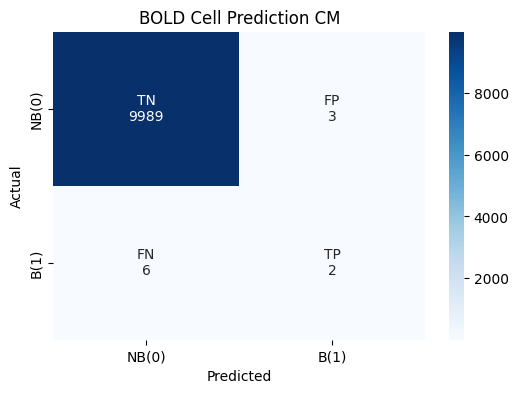


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0
0,1
2,1
3,1
4,1
6,1



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0
0,1
6,1
16,1
23,1
28,1
39,1
45,1
63,1


In [ ]:
# Inference on single position of train_loader
infer_one(
    trained_model=trained_model,
    infer_loader=train_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/1k_val/1-s2.0-S0041008X19303655-mmc4.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
No bold cells in the actual data.

NB to B ratio: Predicted = 9928:72 | Actual = 10000:0
Accuracy: 99.28% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



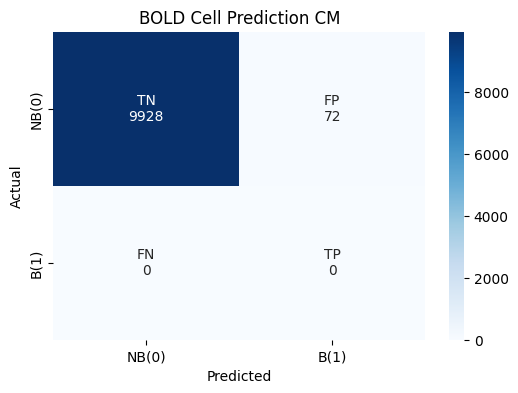


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,11
0,1,1,1,1,1,1,1,1,1,0,0
1,1,1,1,1,1,1,1,1,1,1,0
2,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,0,1,0,0,1,1,1
5,1,1,1,1,0,0,0,0,0,0,0
6,1,1,1,1,0,0,0,0,0,0,0
7,1,1,1,1,0,0,0,0,0,0,0
8,0,1,1,1,0,0,0,0,0,0,0
9,0,1,1,1,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---
No bold cells in actual data.


In [ ]:
# Inference on single position of val_loader
infer_one(
    trained_model=trained_model,
    infer_loader=val_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)


Filename: ../data/1k_test/1415-bassessment-1.xlsx

--- Unique Sigmoid Probabilities for Bold Cells ---
(8,6): 0.932737 | (8,5): 0.935658 | (8,0): 0.936445 | (6,0): 0.937201 | (8,4): 0.937397 | (8,1): 0.938378 | (8,2): 0.938506 | (8,3): 0.938567

NB to B ratio: Predicted = 9978:22 | Actual = 9992:8
Accuracy: 99.80% | Precision: 22.73% | Recall: 62.50% | F1-Score: 0.33



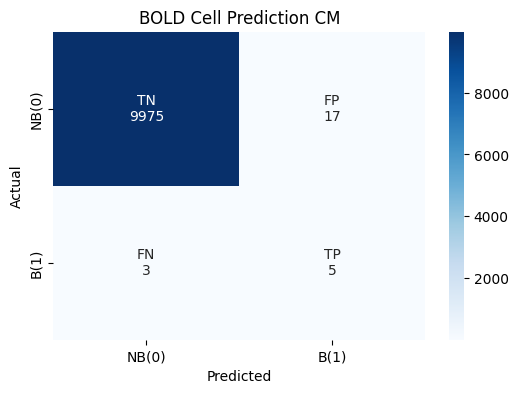


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4
0,1,1,0,0,0
1,1,1,0,0,0
2,1,1,0,0,0
3,1,1,0,0,0
4,1,1,0,0,0
6,1,0,0,0,0
8,0,1,1,1,1
9,0,1,1,1,1
10,0,1,0,1,0
11,0,0,0,1,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6
6,1,0,0,0,0,0,0
8,1,1,1,1,1,1,1


In [ ]:
# Inference on single position of test_loader
infer_one(
    trained_model=trained_model,
    infer_loader=test_loader,
    loc=loc,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
    disp_sig=True,
)

## All Examples

Batch Inference: 100%|██████████| 67/67 [00:17<00:00,  3.79it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 7975209:24791 | Actual = 7975154:24846
Accuracy: 99.52% | Precision: 21.68% | Recall: 36.65% | F1-Score: 0.22



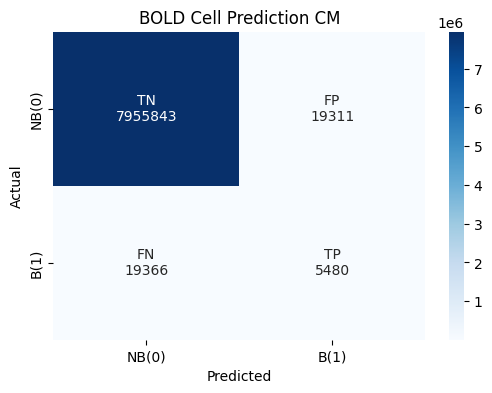

In [ ]:
# Infer across all examples of train_loader
infer_full(
    trained_model=trained_model,
    infer_loader=train_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 996829:3171 | Actual = 997147:2853
Accuracy: 99.51% | Precision: 23.13% | Recall: 28.63% | F1-Score: 0.22



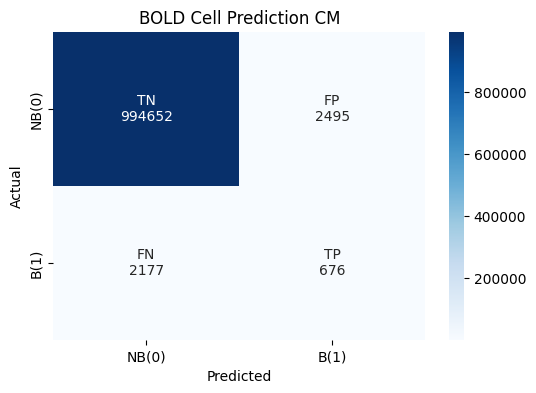

In [ ]:
# Infer across all examples of val_loader
infer_full(
    trained_model=trained_model,
    infer_loader=val_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)

Batch Inference: 100%|██████████| 9/9 [00:02<00:00,  4.06it/s]



--- Aggregated Metrics Across All Batches ---

NB to B ratio: Predicted = 996992:3008 | Actual = 997320:2680
Accuracy: 99.57% | Precision: 25.71% | Recall: 31.76% | F1-Score: 0.26



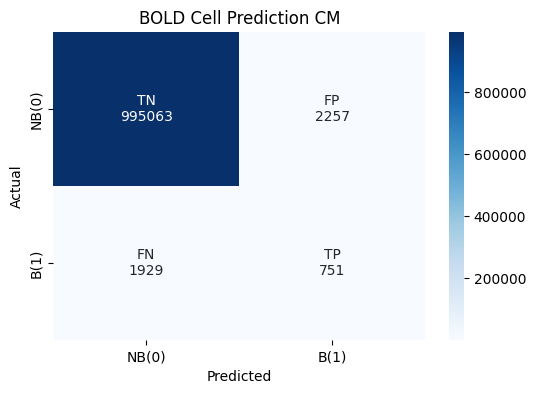

In [ ]:
# Infer across all examples of test_loader
infer_full(
    trained_model=trained_model,
    infer_loader=test_loader,
    batch_size=infer_batch_size,
    threshold=thresh,
    device=DEVICE,
    approach=config["approach"],
)